# Trashnet Classification

#### This notebook outlines a custom Resnet-based Model used to classify the Trashnet Dataset on Kaggle
dataset: https://www.kaggle.com/datasets/feyzazkefe/trashnet

#### Initial testing on Resnet-18 alone led to extreme overfitting

#### Steps taken to reduce overfitting:
* Augment Data using crops and flips
* Implement a custom Resnet-based model, with a dropout layer before the final layer
* Freeze all convulational layers except for layer 4 in Resnet
* Apply L2 regularisation with weight_decay in optimizer

### Test Train Split

In [ ]:
import os
from pathlib import Path
import shutil
import random
from tqdm import tqdm

# Paths
source_dir = Path('/kaggle/input/trashnet/dataset-resized')
output_dir = Path('/kaggle/working/trashnet')
train_dir = output_dir / 'train'
test_dir = output_dir / 'test'


In [3]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

split_ratio = 0.8  # 80% train, 20% test

styles = os.listdir(source_dir)

for style in tqdm(styles):
    style_folder =source_dir / style
    if not os.path.isdir(style_folder):
        continue

    images = os.listdir(style_folder)
    random.shuffle(images)

    split_idx = int(len(images) * split_ratio)
    train_images = images[:split_idx]
    test_images = images[split_idx:]

    os.makedirs(train_dir/style, exist_ok=True)
    os.makedirs(test_dir/style, exist_ok=True)

    for img in train_images:
        src = os.path.join(style_folder, img)
        dst = os.path.join(train_dir, style, img)
        if os.path.isfile(src): # Check if it's a file before copying
            shutil.copy2(src, dst)

    for img in test_images:
        src = os.path.join(style_folder, img)
        dst = os.path.join(test_dir, style, img)
        if os.path.isfile(src): # Check if it's a file before copying
            shutil.copy2(src, dst)

100%|██████████| 6/6 [00:11<00:00,  1.98s/it]


### Prepare Data

In [1]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

In [4]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(
    root = train_dir,
    transform = train_transforms
)

test_dataset = ImageFolder(
    root = test_dir,
    transform = test_transforms
)

len(train_dataset),len(test_dataset)

(2019, 508)

In [5]:
class_names = train_dataset.classes

In [6]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers= os.cpu_count()
)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers= os.cpu_count()
)

print(f"Num train batches:{len(train_dataloader)},Num test batches:{len(test_dataloader)}")

Num train batches:64,Num test batches:16


### Visualise Randomly

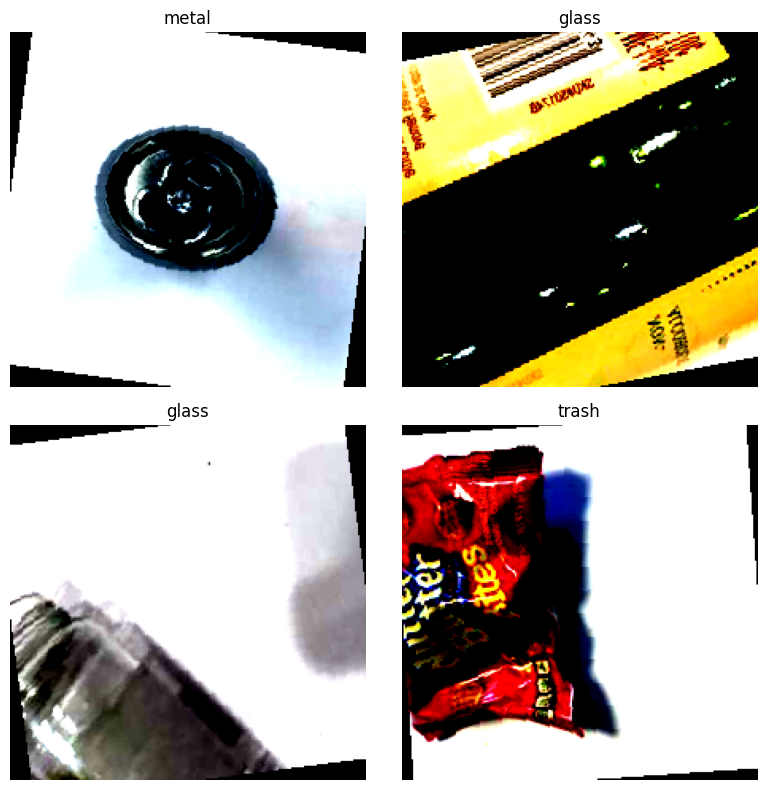

In [7]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_dataloader))

# Select 4 random images from batch 1
random_indices = random.sample(range(len(images)), 4)
selected_images = [images[i] for i in random_indices]
selected_labels = [labels[i] for i in random_indices]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

for i in range(4):
    img_np = selected_images[i].permute(1, 2, 0).numpy()
    axes[i].imshow(img_np)
    axes[i].set_title(f"{class_names[selected_labels[i]]}")
    axes[i].axis(False)

plt.tight_layout()
plt.show()

## Prepare Test & Train Loop

In [9]:
import torch
from torch import nn

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer = torch.optim.Optimizer,
               device=device):

  model.train()

  train_loss, train_acc = 0, 0

  for batch,(X,y) in enumerate(dataloader):

    X,y = X.to(device),y.to(device)

    y_pred_logit = model(X)
    y_pred = torch.argmax(torch.softmax(y_pred_logit,dim=1),dim=1)

    loss = loss_fn(y_pred_logit,y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    train_acc += (y_pred == y).sum().item() / len(y_pred)



  avg_train_loss = train_loss / len(dataloader)
  avg_train_acc = train_acc / len(dataloader)

  return avg_train_loss, avg_train_acc


In [13]:
def test_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               device=device):

  model.eval()

  test_loss, test_acc = 0, 0

  y_preds = []
  y_true = []

  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):

      X,y = X.to(device),y.to(device)

      y_pred_logit = model(X)
      y_pred = torch.argmax(torch.softmax(y_pred_logit,dim=1),dim=1)

      y_preds.extend(y_pred.cpu().numpy())
      y_true.extend(y.cpu().numpy())

      loss = loss_fn(y_pred_logit,y)
      test_loss += loss.item()

      test_acc += (y_pred == y).sum().item() / len(y_pred)


  avg_test_loss = test_loss / len(dataloader)
  avg_test_acc = test_acc / len(dataloader)

  return avg_test_loss, avg_test_acc, y_preds, y_true

In [14]:
from tqdm.auto import tqdm
import numpy as np # Import numpy for comparing floats

def train(model: nn.Module,
          train_dataloader: DataLoader,
          test_dataloader: DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs:int,
          device=device,
          patience: int = 5,
          min_delta: float = 0.01):

  results = {
      "train_loss":[],
      "train_acc":[],
      "test_loss":[],
      "test_acc":[]
  }

  best_test_loss = float('inf')
  epochs_no_improve = 0

  for epoch in tqdm(range(epochs)):

    # train
    train_loss, train_acc = train_step(
        model=model,
        dataloader = train_dataloader,
        loss_fn = loss_fn,
        optimizer = optimizer,
        device=device
    )

    # test
    test_loss, test_acc, y_preds, y_true = test_step(
        model = model,
        dataloader = test_dataloader,
        loss_fn = loss_fn,
        device=device
    )

    print(
      f"Epoch: {epoch+1} | "
      f"train_loss: {train_loss:.4f} | "
      f"train_acc: {train_acc:.4f} | "
      f"test_loss: {test_loss:.4f} | "
      f"test_acc: {test_acc:.4f}"
    )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    # early stopping logic
    if test_loss < best_test_loss - min_delta:
        best_test_loss = test_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve == patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break


  return results, y_preds, y_true

## Prepare Metrics Evaluation

In [15]:
import matplotlib.pyplot as plt

def plot_loss_curves(results):

  '''Plots loss curves of a results dictionary.'''

  plt.figure(figsize=(15, 7))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(results["train_loss"], label="train_loss")
  plt.plot(results["test_loss"], label="test_loss")
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(results["train_acc"], label="train_accuracy")
  plt.plot(results["test_acc"], label="test_accuracy")
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.show()

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_conf_matrix(y_true,y_preds):

  '''Plots a confusion matrix '''

  cm = confusion_matrix(y_true,y_preds)

  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted Style')
  plt.ylabel('True Style')
  plt.title('Confusion Matrix')
  plt.show()

### Model: Resnet-18 with Dropout Layer

In [17]:
import torchvision.models as models
from torch import nn

class ResnetWithDropout(nn.Module):
    def __init__(self, base_model,num_classes, dropout_rate=0.5):
        super().__init__()
        self.base = nn.Sequential(*list(base_model.children())[:-1])  # exc fc
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(base_model.fc.in_features, num_classes)

    def forward(self, x):
        x = self.base(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [18]:
model_resnet_base = models.resnet50(pretrained=True)
for param in model_resnet_base.parameters():
    param.requires_grad = False 
for param in model_resnet_base.layer4.parameters():
    param.requires_grad = True  # unfreeze last conv

model_resnet = ResnetWithDropout(
    base_model=model_resnet_base,
    num_classes=len(class_names)
)
model_resnet.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s]


ResnetWithDropout(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

In [19]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_resnet.parameters(),lr=1e-4, weight_decay=1e-5)

In [20]:
NUM_EPOCHS = 50

from timeit import default_timer as timer

start_time = timer()

results_resnet18, y_preds_resnet18, y_true_resnet18 = train(
    model=model_resnet,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs= NUM_EPOCHS,
    device=device
)

end_time = timer()
print(f"Total training time: {end_time-start_time:.2f}s")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8679 | train_acc: 0.1494 | test_loss: 1.7892 | test_acc: 0.1975
Epoch: 2 | train_loss: 1.7987 | train_acc: 0.2103 | test_loss: 1.7291 | test_acc: 0.2464
Epoch: 3 | train_loss: 1.7566 | train_acc: 0.2327 | test_loss: 1.6956 | test_acc: 0.2857
Epoch: 4 | train_loss: 1.7159 | train_acc: 0.2450 | test_loss: 1.6658 | test_acc: 0.3186
Epoch: 5 | train_loss: 1.6954 | train_acc: 0.2642 | test_loss: 1.6490 | test_acc: 0.3477
Epoch: 6 | train_loss: 1.6686 | train_acc: 0.2826 | test_loss: 1.6283 | test_acc: 0.3789
Epoch: 7 | train_loss: 1.6528 | train_acc: 0.3035 | test_loss: 1.6082 | test_acc: 0.3920
Epoch: 8 | train_loss: 1.6482 | train_acc: 0.3081 | test_loss: 1.5912 | test_acc: 0.4311
Epoch: 9 | train_loss: 1.6176 | train_acc: 0.3262 | test_loss: 1.5772 | test_acc: 0.4562
Epoch: 10 | train_loss: 1.6044 | train_acc: 0.3511 | test_loss: 1.5624 | test_acc: 0.4646
Epoch: 11 | train_loss: 1.5959 | train_acc: 0.3555 | test_loss: 1.5377 | test_acc: 0.4944
Epoch: 12 | train_l

### Loss Curve

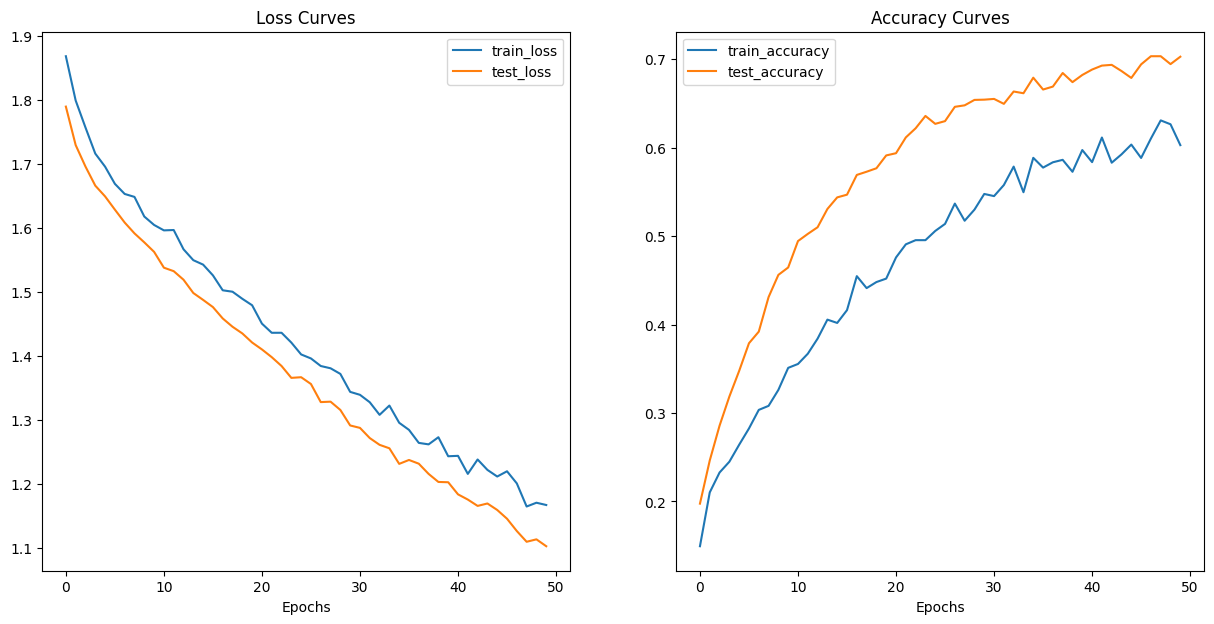

In [21]:
plot_loss_curves(results_resnet18)

#### Final Accuracy after 50 epochs: 70%

### Confusion Matrix

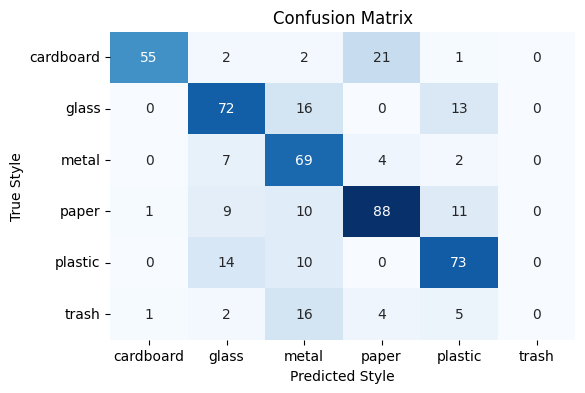

In [22]:
plot_conf_matrix(y_true_resnet18,y_preds_resnet18)

* Paper is the best classified material
* It is significant to note that trash is never correctly classified as trash; this could be because 'trash' is a diverse category, making it difficult to recognise patterns visually (humans rely on pre-defined notions of what 'trash' is).
